In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm

# Load data
data = pd.read_csv('../dataset/process/tweets_convert_cleaned.tsv', sep='\t')
data['emo'] = data['emo'].fillna("Nan")
data = data.dropna(subset=['text'])

X_text = data['text'].values
X_emo = data['emo'].values
y = data['sentiment'].values

# Split data
X_text_train, X_text_temp, X_emo_train, X_emo_temp, y_train, y_temp = train_test_split(X_text, X_emo, y, test_size=0.3, random_state=42)
X_text_val, X_text_test, X_emo_val, X_emo_test, y_val, y_test = train_test_split(X_text_temp, X_emo_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train size: {len(X_text_train)}')
print(f'Validation size: {len(X_text_val)}')
print(f'Test size: {len(X_text_test)}')

# Preprocess function
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", ' ', s)
    s = re.sub(r"\d", '', s)
    return s

# Tokenize function
def tokenize(x_train, x_val, x_test):
    word_list = []
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # Create a vocabulary index
    vocab = {word: idx for idx, (word, _) in enumerate(corpus.items(), 1)}

    def encode(sentences):
        return [[vocab[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in vocab] for sent in sentences]

    x_train_encoded = encode(x_train)
    x_val_encoded = encode(x_val)
    x_test_encoded = encode(x_test)
    
    # Pad sequences
    x_train_padded = pad_sequence([torch.tensor(x) for x in x_train_encoded], batch_first=True, padding_value=0)
    x_val_padded = pad_sequence([torch.tensor(x) for x in x_val_encoded], batch_first=True, padding_value=0)
    x_test_padded = pad_sequence([torch.tensor(x) for x in x_test_encoded], batch_first=True, padding_value=0)
    
    return x_train_padded, x_val_padded, x_test_padded, vocab

# Preprocess and tokenize the text
X_train_padded, X_val_padded, X_test_padded, vocab = tokenize(X_text_train, X_text_val, X_text_test)

# Preprocess and tokenize the emo feature
emo_vocab = {word: idx for idx, (word, _) in enumerate(Counter([preprocess_string(word) for sent in X_emo for word in sent.lower().split()]).items(), 1)}

def encode_emo(sentences):
    return [[emo_vocab[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in emo_vocab] for sent in sentences]

X_emo_train_encoded = encode_emo(X_emo_train)
X_emo_val_encoded = encode_emo(X_emo_val)
X_emo_test_encoded = encode_emo(X_emo_test)

# Pad sequences
X_emo_train_padded = pad_sequence([torch.tensor(x) for x in X_emo_train_encoded], batch_first=True, padding_value=0)
X_emo_val_padded = pad_sequence([torch.tensor(x) for x in X_emo_val_encoded], batch_first=True, padding_value=0)
X_emo_test_padded = pad_sequence([torch.tensor(x) for x in X_emo_test_encoded], batch_first=True, padding_value=0)

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

# Load pre-trained GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    return embeddings_index

glove_embeddings = load_glove_embeddings('../dataset/glove_twitter_27B/glove.twitter.27B.100d.txt')

# Check for missing words in GloVe
missing_words = [word for word in vocab.keys() if word not in glove_embeddings]
print(f'Missing words in GloVe: {len(missing_words)}/{len(vocab)}')

# Create embedding matrix for text
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
for word, i in vocab.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create random embedding matrix for emo (since GloVe embeddings for emojis are not available)
emo_embedding_dim = 100
emo_embedding_matrix = np.random.rand(len(emo_vocab) + 1, emo_embedding_dim)

class SentimentBiLSTM(nn.Module):
    def __init__(self, vocab_size, emo_vocab_size, embedding_dim, emo_embedding_dim, hidden_dim, output_dim, n_layers, dropout, embedding_matrix, emo_embedding_matrix):
        super(SentimentBiLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.emo_embedding = nn.Embedding.from_pretrained(torch.tensor(emo_embedding_matrix, dtype=torch.float32))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2 + emo_embedding_dim, output_dim)  # *2 because of bidirectional
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, emo):
        embedded = self.dropout(self.embedding(x))
        emo_embedded = self.dropout(self.emo_embedding(emo))
        lstm_out, _ = self.lstm(embedded)
        final_feature_map = self.dropout(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:], emo_embedded[:, -1, :]), dim=1))
        final_out = self.fc(final_feature_map)
        return final_out


Train size: 87145
Validation size: 18674
Test size: 18675
Missing words in GloVe: 17102/59427


In [3]:
# Hyperparameters
vocab_size = len(vocab) + 1
emo_vocab_size = len(emo_vocab) + 1
hidden_dim = 256
output_dim = 3
n_layers = 2
dropout = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentBiLSTM(vocab_size, emo_vocab_size, embedding_dim, emo_embedding_dim, hidden_dim, output_dim, n_layers, dropout, embedding_matrix, emo_embedding_matrix)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
# Accuracy calculation function
def calculate_accuracy(preds, y):
    _, pred_classes = torch.max(preds, 1)
    correct = (pred_classes == y).sum().item()
    return correct / len(y)

# Training loop with early stopping
epochs = 10
patience = 3
best_val_loss = float('inf')
early_stopping_counter = 0

train_losses_over_time = []
val_losses_over_time = []

for epoch in range(epochs):
    model.train()
    train_losses = []
    train_accuracies = []
    for inputs, emos, labels in tqdm(DataLoader(TensorDataset(X_train_padded, X_emo_train_padded, y_train_tensor), batch_size=64, shuffle=True)):
        inputs, emos, labels = inputs.to(device), emos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, emos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_accuracies.append(calculate_accuracy(outputs, labels))

    model.eval()
    val_losses = []
    val_accuracies = []
    with torch.no_grad():
        for inputs, emos, labels in tqdm(DataLoader(TensorDataset(X_val_padded, X_emo_val_padded, y_val_tensor), batch_size=64, shuffle=False)):
            inputs, emos, labels = inputs.to(device), emos.to(device), labels.to(device)
            outputs = model(inputs, emos)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            val_accuracies.append(calculate_accuracy(outputs, labels))

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    train_accuracy = np.mean(train_accuracies)
    val_accuracy = np.mean(val_accuracies)
    
    train_losses_over_time.append(train_loss)
    val_losses_over_time.append(val_loss)
    
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_two_bilstm_model.pt')
    # else:
    #     early_stopping_counter += 1
    #     if early_stopping_counter >= patience:
    #         print('Early stopping')
    #         break

100%|██████████| 292/292 [00:40<00:00,  7.22it/s]


Epoch 1/10, Training Loss: 0.8755127693062837, Validation Loss: 0.8085319093645436, Training Accuracy: 0.5869221419361771, Validation Accuracy: 0.632007705479452


100%|██████████| 292/292 [00:42<00:00,  6.80it/s]


Epoch 2/10, Training Loss: 0.8420637012315741, Validation Loss: 0.7980013371330418, Training Accuracy: 0.6092720309086351, Validation Accuracy: 0.6374507705479452


100%|██████████| 292/292 [00:43<00:00,  6.67it/s]


Epoch 3/10, Training Loss: 0.8267957966845816, Validation Loss: 0.7899127561752111, Training Accuracy: 0.6209800083270657, Validation Accuracy: 0.6407448630136986


100%|██████████| 292/292 [00:33<00:00,  8.81it/s]


Epoch 4/10, Training Loss: 0.8160548267473033, Validation Loss: 0.7899438357108259, Training Accuracy: 0.625821234465098, Validation Accuracy: 0.6363035102739726


100%|██████████| 292/292 [00:28<00:00, 10.33it/s]


Epoch 5/10, Training Loss: 0.8074380667899324, Validation Loss: 0.7832228080050586, Training Accuracy: 0.6298823578131155, Validation Accuracy: 0.6428553082191781


100%|██████████| 292/292 [00:28<00:00, 10.38it/s]


Epoch 6/10, Training Loss: 0.7974519736616272, Validation Loss: 0.7762248107831772, Training Accuracy: 0.636542611296157, Validation Accuracy: 0.6468835616438355


100%|██████████| 292/292 [00:27<00:00, 10.44it/s]


Epoch 7/10, Training Loss: 0.7901993821458494, Validation Loss: 0.770674856149987, Training Accuracy: 0.6408891381039361, Validation Accuracy: 0.6490625


100%|██████████| 292/292 [00:28<00:00, 10.30it/s]


Epoch 8/10, Training Loss: 0.7831252429978963, Validation Loss: 0.7761638746277927, Training Accuracy: 0.6435061759070234, Validation Accuracy: 0.6499336472602739


100%|██████████| 292/292 [00:28<00:00, 10.25it/s]


Epoch 9/10, Training Loss: 0.7777884115906714, Validation Loss: 0.7671418367591623, Training Accuracy: 0.6467004561978439, Validation Accuracy: 0.6498266267123287


100%|██████████| 292/292 [00:28<00:00, 10.41it/s]

Epoch 10/10, Training Loss: 0.7712254326861685, Validation Loss: 0.7686489120329896, Training Accuracy: 0.6497226549908671, Validation Accuracy: 0.6500256849315069


100%|██████████| 292/292 [00:27<00:00, 10.58it/s]


Test Accuracy: 0.6509871071716358


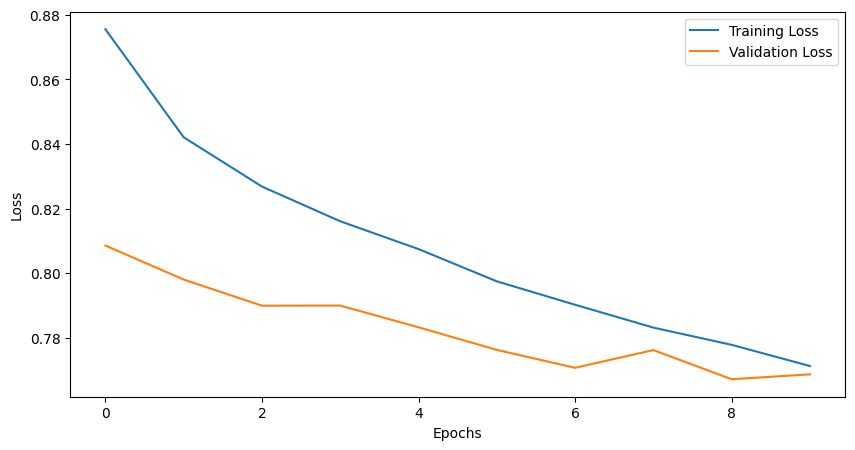

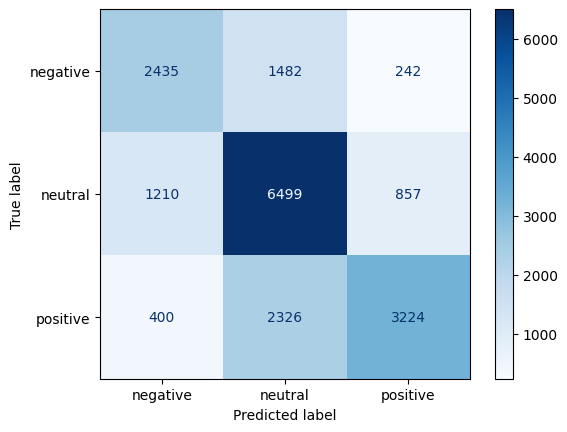

In [5]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_two_bilstm_model.pt'))
model.eval()
test_accuracies = []
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, emos, labels in tqdm(DataLoader(TensorDataset(X_test_padded, X_emo_test_padded, y_test_tensor), batch_size=64, shuffle=False)):
        inputs, emos, labels = inputs.to(device), emos.to(device), labels.to(device)
        outputs = model(inputs, emos)
        test_accuracies.append(calculate_accuracy(outputs, labels))
        all_preds.append(outputs.cpu())
        all_labels.append(labels.cpu())

test_accuracy = np.mean(test_accuracies)
print(f'Test Accuracy: {test_accuracy}')

# Plot loss over time
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses_over_time)), train_losses_over_time, label='Training Loss')
plt.plot(range(len(val_losses_over_time)), val_losses_over_time, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot confusion matrix
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
_, pred_classes = torch.max(all_preds, 1)
cm = confusion_matrix(all_labels, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()